In [12]:
%load_ext autoreload
%autoreload 2

import genops
import einops

from functools import partial
from pystruct.utils import make_grid_edges, generate_binary_edges
from pystruct.inference.lbp import compute_energy_plus, lbp_plus
from pystruct.inference.mean_field import naive_mean_field
from pystruct.inference.inference_methods import inference_ad3

from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
genops.set_backend(genops.NUMPY)

size = 40
n_states = 20

with genops.local_seed(1):
    x = genops.normal(shape=[size, size, n_states])
    binary_edges = genops.convert(make_grid_edges(x))
    binary_potentials = genops.normal(shape=[binary_edges.shape[0], n_states, n_states])
    unary_potentials = x.reshape(-1, n_states)
    args = (unary_potentials, binary_potentials, binary_edges)
    E = partial(compute_energy_plus, *args)

(4682.325321388592, 5640.304005766117)

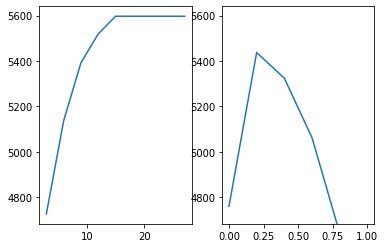

In [15]:
iter_nums = list(range(3, 30, 3))
dampings = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

plt.subplots(1, 2)

plt.subplot(1, 2, 1)
energies = []
for iter_num in iter_nums:
    energies.append(E(labels=naive_mean_field(*args, max_iter=iter_num, damping=0.2)))
plt.plot(iter_nums, energies, label=f'iters')
b, t = plt.ylim()

plt.subplot(1, 2, 2)
energies = []
for damping in dampings:
    energies.append(E(labels=naive_mean_field(*args, max_iter=10, damping=damping)))
plt.plot(dampings, energies, label=f'damping')
plt.ylim((b, t))

In [17]:
%timeit naive_mean_field(*args, max_iter=20)
%timeit lbp_plus(*args, max_iter=20)

55 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
249 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Benchmark on Potts Model

- LBP is much more stable than MF.
- MF can get similar results to LBP.

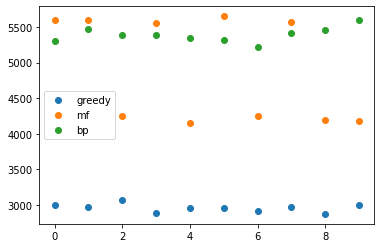

In [26]:
genops.set_backend(genops.NUMPY)

size = 40
n_states = 20

expids = list(range(10))
record = []
for expid in expids:
    with genops.local_seed(expid):
        x = genops.normal(shape=[size, size, n_states])
        binary_edges = genops.convert(make_grid_edges(x))
        binary_potentials = genops.normal(shape=[binary_edges.shape[0], n_states, n_states])
        unary_potentials = x.reshape(-1, n_states)
        args = (unary_potentials, binary_potentials, binary_edges)
        E = partial(compute_energy_plus, *args)

        greedy = E(labels=genops.argmax(unary_potentials, axis=1))
        mf = E(labels=naive_mean_field(*args, max_iter=20, damping=0.2, track_best=False))
        bp = E(labels=lbp_plus(*args, max_iter=20, track_best=False))
        # print(E(labels=inference_ad3(*args)))

        record.append([greedy, mf, bp])

plt.scatter(expids, genops.tensor(record)[:, 0], label='greedy')
plt.scatter(expids, genops.tensor(record)[:, 1], label='mf')
plt.scatter(expids, genops.tensor(record)[:, 2], label='bp')
plt.legend()

## Benchmark on Chain-Like CRF

Chain-Like CRF means: `A-B-C-D-E`, while some skip-binaries in a fixed window exist (`A-C`, `B-D`, `C-E`).

- LBP is always more stable than MF.
- The less factors, the better LBP.

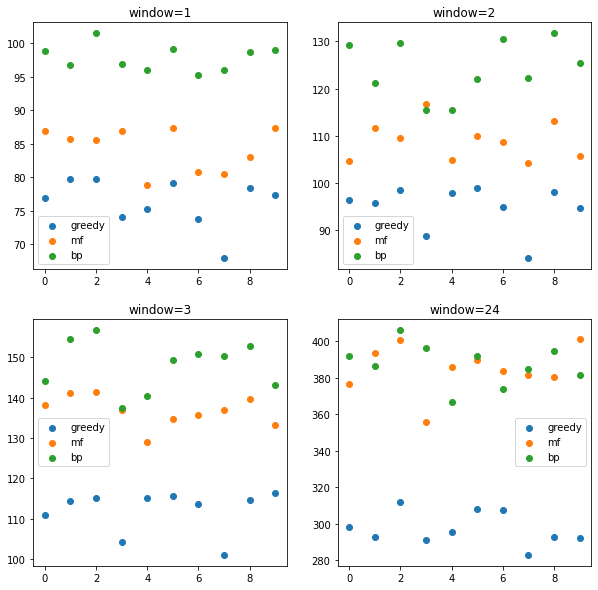

In [25]:
genops.set_backend(genops.NUMPY)

size = 25
n_states = 32

plt.subplots(2, 2, figsize=(10, 10))

for wid, window in enumerate([1, 2, 3, size-1]):
    plt.subplot(2, 2, wid + 1)
    expids = list(range(10))
    record = []

    for expid in expids:
        with genops.local_seed(expid):            
            unary_potentials = genops.abs(genops.normal(shape=(size, n_states)))

            binary_edges = genops.tensor(generate_binary_edges(size, window))
            binary_potentials = genops.abs(genops.normal(shape=(binary_edges.shape[0], n_states, n_states)))

            args = (unary_potentials, binary_potentials, binary_edges)
            E = partial(compute_energy_plus, *args)

            greedy = E(labels=genops.argmax(unary_potentials, axis=1))
            mf = E(labels=naive_mean_field(*args, max_iter=20, damping=0.2, track_best=True))
            bp = E(labels=lbp_plus(*args, max_iter=20, track_best=True))
            # print(E(labels=inference_ad3(*args)))

            record.append([greedy, mf, bp])

    plt.scatter(expids, genops.tensor(record)[:, 0], label='greedy')
    plt.scatter(expids, genops.tensor(record)[:, 1], label='mf')
    plt.scatter(expids, genops.tensor(record)[:, 2], label='bp')
    plt.legend()
    plt.title(f"window={window}")